# Residual Networks

- Help with vanishing and exploding weight problems
- Training error in theory go down as you add more layers , But in reality the training error will go up after going down for a while and this is what is resnet for.

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/resnets_1.png"/>

Why do ResNets work ?
- It easy for the NN to learn the identity function , 
- Adding more layers will not hurt performance , instead if you are lucky it will enhance it .
- What if $a^{l}$of n dimension , $a^{l+1}$ of m dimension : you can use fix weights matrix W of size $m*n$ ,  $W*a^{l}$ will be of m dimensions


In [1]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense,Add, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from kt_utils import *
from keras.initializers import glorot_uniform

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.


In [2]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


In [3]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path 
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X_shortcut,X])
    X = Activation('relu')(X)
    return X

In [4]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s),padding='valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    # Second component of main path
    X = Conv2D(F2, (f, f), strides = (1,1),padding='same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)
    
    # Third component of main path
    X = Conv2D(F3, (1, 1), strides = (1,1),padding='valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base+ '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)
    
    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X,X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [5]:
def ResNet50(input_shape = (64, 64, 3), classes = 2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    # Stage 3
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f = 3, filters =  [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3,  [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3,  [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name='max_pool')(X)

    # output layer
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [6]:
resnet = ResNet50((64,64,3))
resnet.compile(optimizer="Adam",loss="binary_crossentropy", metrics = ["accuracy"])

In [7]:
resnet.fit(x=X_train,y=Y_train,epochs=20,batch_size=64)

Epoch 1/20
600/600 [==============================] - 151s - loss: 3.0515 - acc: 0.4867   
Epoch 2/20
600/600 [==============================] - 159s - loss: 1.0968 - acc: 0.5767   
Epoch 3/20
600/600 [==============================] - 150s - loss: 0.8443 - acc: 0.5267   
Epoch 4/20
600/600 [==============================] - 164s - loss: 0.7820 - acc: 0.7283   
Epoch 5/20
600/600 [==============================] - 163s - loss: 0.6848 - acc: 0.7350   
Epoch 6/20
600/600 [==============================] - 169s - loss: 0.4159 - acc: 0.8867   
Epoch 7/20
600/600 [==============================] - 171s - loss: 0.2217 - acc: 0.9483   
Epoch 8/20
600/600 [==============================] - 198s - loss: 0.1669 - acc: 0.9583   
Epoch 9/20
600/600 [==============================] - 161s - loss: 0.1717 - acc: 0.9500   
Epoch 10/20
600/600 [==============================] - 154s - loss: 0.4087 - acc: 0.8933   
Epoch 11/20
600/600 [==============================] - 155s - loss: 0.2311 - acc: 0.9333 

In [8]:
resnet.fit(x=X_train,y=Y_train,epochs=20,batch_size=128)

Epoch 1/20
600/600 [==============================] - 146s - loss: 0.0294 - acc: 0.9900    
Epoch 2/20
600/600 [==============================] - 144s - loss: 0.0341 - acc: 0.9883    
Epoch 3/20
600/600 [==============================] - 147s - loss: 0.0149 - acc: 0.9950    
Epoch 4/20
600/600 [==============================] - 145s - loss: 0.0152 - acc: 0.9950    
Epoch 5/20
600/600 [==============================] - 149s - loss: 0.0092 - acc: 0.9967    
Epoch 6/20
600/600 [==============================] - 146s - loss: 0.0088 - acc: 0.9950    
Epoch 7/20
600/600 [==============================] - 146s - loss: 0.0026 - acc: 1.0000    
Epoch 8/20
600/600 [==============================] - 147s - loss: 0.0039 - acc: 0.9983    
Epoch 9/20
600/600 [==============================] - 145s - loss: 0.0017 - acc: 1.0000    
Epoch 10/20
600/600 [==============================] - 146s - loss: 0.0010 - acc: 1.0000        
Epoch 11/20
600/600 [==============================] - 162s - loss: 0.0010 

### Overfit the training set

In [9]:
preds = resnet.evaluate(x=X_test,y=Y_test)

print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 12s    

Loss = 0.79835193634
Test Accuracy = 0.61333332936


In [10]:
resnet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D) (None, 70, 70, 3)     0           input_1[0][0]                    
____________________________________________________________________________________________________
conv1 (Conv2D)                   (None, 32, 32, 64)    9472        zero_padding2d_1[0][0]           
____________________________________________________________________________________________________
bn_conv1 (BatchNormalization)    (None, 32, 32, 64)    256         conv1[0][0]                      
___________________________________________________________________________________________

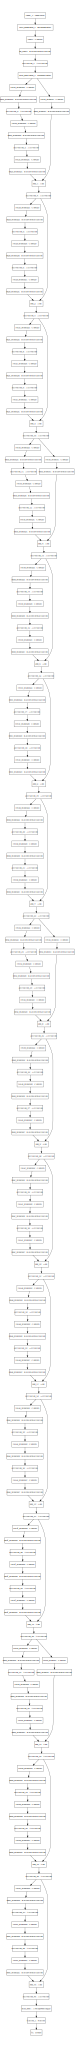

In [11]:
plot_model(resnet, to_file='resnet.png')
SVG(model_to_dot(resnet).create(prog='dot', format='svg'))

<img src="images/resnet-architecture.png"/>